In [85]:
import numpy as np
from scipy import ndimage as nd
import math
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [86]:
# Gradient in x-direction
def Sobelx(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])
    Ix = nd.convolve(image,sobelx)           
    return Ix


# Gradient in y-direction
def Sobely(image):
    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Iy = nd.convolve(image,sobely)
    return Iy


# Convert RGB to grayscale
def rgb2gray(image):
    image = np.array(image)
    r, c, ch = image.shape
    gray = np.zeros([r,c])

    gray = np.mean(image, axis=2)
    return gray


# Reduce image size
def reduceRes(image,factor):
    r,c = image.size
    r = int(np.floor(r/factor))
    c = int(np.floor(c/factor))
    new = image.resize((r,c))
    return new


# Box filter for smoothing
def boxFilter(image,rc):
    box = np.ones([rc,rc])/rc**2
    image = nd.convolve(image,box)
    return image


# Pad image with zeros
def pad(image,filter):
    r,c = filter.shape
    factor = int(np.floor(r/2))

    r_img, c_img = image.shape
    pad = np.zeros([r_img,factor])
    image = np.hstack([pad,image,pad])

    r_img, c_img = image.shape
    pad = np.zeros([factor,c_img])
    image = np.vstack([pad,image,pad])

    return image


# Normalized Cross Correlation
def norm_cross_corr(image,filter):
    r,c = image.shape
    ncc = np.zeros([r,c])
    
    padded = pad(image,filter)

    for i in range(r):
        for j in range(c):
            f = padded[i:i+filter.shape[0],j:j+filter.shape[1]]
            len_f = np.sqrt(np.sum(f**2))
            if len_f==0:
                norm_f = np.zeros(f.shape)
            else:
                norm_f = f/len_f
            norm_g = filter/np.sqrt(np.sum(filter**2))

            if filter.size != norm_f.size:
                print('Norm F:', norm_f)
                print('Filter:',filter)
            
            norm_f = np.reshape(norm_f,[1,filter.size])
            norm_g = np.reshape(norm_g,[filter.size,1])
            ncc[i,j] = np.dot(norm_f,norm_g)
            
    return ncc


# Harris Corner Detector
def HarrisCorner(image,threshold,width):
    
    # Peak finding for nonmax supression
    def peaks(image,window):
        factor = int(np.floor(window.shape[0]/2))
        image = pad(image,window)
        peaks = np.zeros([image.shape[0],image.shape[1]])

        for i in range(1,image.shape[0]-1):
            for j in range(1,image.shape[1]-1):
                window = image[i-1:i+2,j-1:j+2]
                if image[i,j]==np.amax(window):
                    peaks[i,j] = image[i,j]


        # remove padding
        peaks = peaks[factor:-factor,factor:-factor]

        return peaks

    # remove corners that are near the edge
    def nearEdge(corners,width):
        '''
        # Remove isolated corners in a window
        good_corners = np.copy(corners)
        good_corners[good_corners>0] = 1
        good_corners[good_corners<0] = 0
        print('Previous corners with edges:', np.sum(good_corners))
        '''
        r,c = corners.shape
        edge = int(np.floor((width-1)/2))
        corners[0:edge,:] = 0
        corners[r-edge:r,:] = 0

        corners[:,0:edge] = 0
        corners[:,c-edge:c] = 0
        '''
        # Remove isolated corners in a window
        good_corners = np.copy(corners)
        good_corners[good_corners>0] = 1
        good_corners[good_corners<0] = 0
        print('Corners after removing edges:', np.sum(good_corners))
        '''
        return corners


    # Find gradients
    Ix = Sobelx(image)
    Iy = Sobely(image)
    Ixx = Ix**2
    Iyy = Iy**2

    # Compute R values
    detM = Ixx*Iyy
    traceM = Ixx+Iyy
    k = 0.05
    R = detM - k*traceM**2

    # Threshold values
    R[R <= threshold*np.amax(R)] = 0
    
    # Nonmax Supression
    R = peaks(R,np.ones([3,3]))

    # Remove corners near the edge
    R = nearEdge(R,width)

    return R


# Reduce threshold until ~1% of pixels are corners
def reducedHarris(image,width):

    threshold = 1.0
    ratio = 101
    while ratio >= 100:
        threshold = 0.1*threshold

        corners = HarrisCorner(image,threshold,width)
        # Number of corners
        idx = np.where(corners>0)
        idx = np.array(idx).T
        ratio = image.size/idx.shape[0]
    
    print('Threshold:',threshold)
    print('Corners:',idx.shape[0])

    return corners


# Draw lines between matches
def drawLines(image1,image2,matches,threshold):

    offset = image1.shape[0]
    x = np.copy(matches[:,0:4:2])
    x[:,1] = x[:,1] + offset
    y = np.copy(matches[:,1:4:2])

    both = np.vstack([image1,image2])
    plt.imshow(both,cmap='gray')
    for i in range(0,x.shape[0]):
        if matches[i,-1] >= threshold:
            plt.plot(y[i,:],x[i,:])
    
    return


# Normalized Cross Correlation of two equal shaped patches
def patchNCC(f,g):

    len_f = np.sqrt(np.sum(f**2))
    norm_f = f/len_f

    len_g = np.sqrt(np.sum(g**2))
    norm_g = g/len_g

    norm_f = np.reshape(norm_f,[1,f.size])
    norm_g = np.reshape(norm_g,[g.size,1])
    ncc = np.dot(norm_f,norm_g)
            
    return ncc


# Find matches from im1 to im2
def patch2patch(im1,im2,corners1,corners2,width,num_matches):

    # Patch from location
    def getPatch(im,r,c,width):
        left = int( (width-1)/2 )
        right = int( (width-1)/2 + 1 )
        patch = im[r-left:r+right,c-left:c+right]
        return patch

    def cornerCoord(corners):
        idx = np.where(corners>0)
        idx = np.array(idx).T
        return idx

    # Find patch coordinates
    coord1 = cornerCoord(corners1)
    coord2 = cornerCoord(corners2)

    matches = np.zeros([num_matches,5])
    
    i = 0
    while i<num_matches:
        r1 = coord1[i,0]
        c1 = coord1[i,1]
        match = np.array([r1,c1,0,0,0])
  
        # Match the patch to second image
        patch1 = getPatch(im1,r1,c1,width)
    
        for j in range(coord2.shape[0]):
            r2 = coord2[j,0]
            c2 = coord2[j,1]
            patch2 = getPatch(im2,r2,c2,width)

            ncc = patchNCC(patch1,patch2)
            if ncc >= match[4]:
                match = [r1,c1,r2,c2,ncc]

        matches[i,:] = match
        i+=1

    return matches

# Load Image, Reduce Size, Convert to Gray

In [87]:
reduce = 5

# Load image1
file = 'DanaHallWay1/DSC_0282.JPG'
image = Image.open(file)
# Reduce resolution
image1 = reduceRes(image,reduce)
# Convert to grayscale
gray1 = rgb2gray(image1)

# Load image2
file = 'DanaHallWay1/DSC_0283.JPG'
image = Image.open(file)
# Reduce resolution
image2 = reduceRes(image,reduce)
# Convert to grayscale
gray2 = rgb2gray(image2)

# Add blurring to reduce noise level

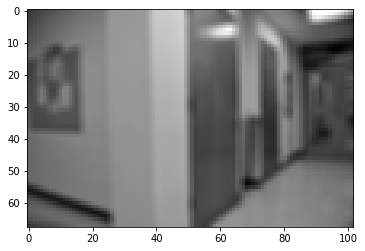

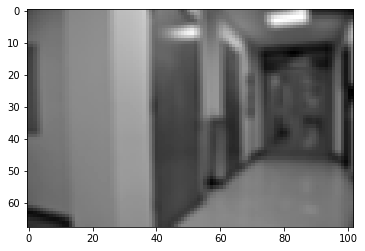

In [88]:
# Smooth image
blur = 3
im1 = boxFilter(gray1,blur)
im2 = boxFilter(gray2,blur)

plt.imshow(im1,cmap='gray')
plt.show()
plt.imshow(im2,cmap='gray')

In [89]:
# Find sparse corners
print('Finding corners...')
width = 7
corners1 = reducedHarris(im1,width)
corners2 = reducedHarris(im2,width)

Finding corners...
Threshold: 0.0010000000000000002
Corners: 74
Threshold: 0.0010000000000000002
Corners: 70


Finding matches...
74 matches found.


/tmp/ipykernel_5331/1521953702.py:253: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  matches[i,:] = match


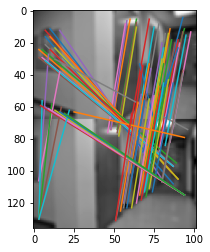

In [90]:
# Find matches
print('Finding matches...')
num_matches = np.sum(corners1>0)
matches = patch2patch(im1,im2,corners1,corners2,width,num_matches)
print(matches.shape[0],'matches found.')
drawLines(im1,im2,matches,0.9)

Finding matches...
70 matches found.


/tmp/ipykernel_5331/1521953702.py:253: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  matches[i,:] = match


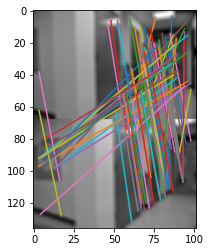

In [91]:
# Find matches
print('Finding matches...')
num_matches = np.sum(corners2>0)
matches = patch2patch(im2,im1,corners2,corners1,width,num_matches)
print(matches.shape[0],'matches found.')
drawLines(im2,im1,matches,0.9)